The repository contains the following packages: config, data, models

__1-__ The __config__ package contains configs of the models and also settings of the project.


__2-__ The __data__ package stores and loads the data needed for the models. It has datasets and data_loaders sub-packages.
The datasets sub-package stores raw data samples; one of our used datasets is CAVE which you can find its full data here: https://www1.cs.columbia.edu/CAVE/databases/multispectral/

In data_loader sub-package, we prepare data samples needed for the models. In reformat_cave_data.py file, we change the CAVE data format to use them for our models. Also, in simulate_data.py we select some random patches from both RGB and HS images to train our models and then simulate functionality of the spectrophotometer.


__3-__ The __models__ package contains our implemented models. At regression.py file, we have implemented a regression model to reconstruct HS images from the corresponding RGB images.


We evaluate our models by using RMSE and delta_e 2000.

At the first we should load the data and select some random patches to train the model. The number of patches and their sizes are:

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from config import PATCHES_NUM, PATCHES_SIZE

patches_num = PATCHES_NUM
print('patches_num: ',patches_num, ', patches_size: ', PATCHES_SIZE)

patches_num:  200 , patches_size:  10


At load_data we have normalized the hyperspectrul image.

In [3]:
import os

from config import DATASETS_DIR
from data.data_loader.simulate_data import load_data, random_patches


folder_path = os.path.join(DATASETS_DIR, 'CAVE', 'balloons_ms')

rgb_img, hs_img = load_data(folder_path)
rgb_patches, hs_patches, patches = random_patches(rgb_img, hs_img, patches_num, PATCHES_SIZE)

Now it's time to simulate functionality of the spectrophotometer.

In [4]:
from data.data_loader.simulate_data import simulate_spectrophotometer

avg_rgb_patches = simulate_spectrophotometer(rgb_patches)
avg_hs_patches = simulate_spectrophotometer(hs_patches)

Then we should split the data to test and train sets with the TRAIN_RATIO of:

In [5]:
from config import TRAIN_RATIO

print(TRAIN_RATIO)

0.8


In [6]:
train_samples = int(TRAIN_RATIO * patches_num)
train_rgb, test_rgb = avg_rgb_patches[:train_samples], avg_rgb_patches[train_samples:]
train_hs, test_hs = avg_hs_patches[:train_samples], avg_hs_patches[train_samples:]

Finally we train the regresson model.

In [7]:
from models.regression import Regression

regresstion = Regression(train_rgb, train_hs)
regresstion.train()
predictions = regresstion.model.predict(test_rgb)

The RMSE score is as follows.

In [8]:
from main import get_rmse, get_delta_e_2000

print('rmse is: ', get_rmse(test_hs, predictions), '\ndelta e is: ', get_delta_e_2000(test_hs, predictions))

rmse is:  4.284021520397678 
delta e is:  32.37193461945616


In [9]:
import seaborn as sns
from main import run
import numpy as np

sns.set(color_codes=True)


def multi_run(method='rgb', normalize=False, patches_size=PATCHES_SIZE):
    rmses = []
    delta_es = []
    for i in range(100):
        rmse, delta_e = run(patches_num, method=method, normalize=normalize,  patches_size=patches_size)
        rmses.append(rmse)
        delta_es.append(delta_e)
    return rmses, delta_es

def get_results(normalize=False, patches_size=PATCHES_SIZE):
    rgb_rmses, rgb_delta_es = multi_run(method='rgb', normalize=normalize, patches_size=patches_size)
    xyz_rmses, xyz_delta_es = multi_run(method='xyz', normalize=normalize, patches_size=patches_size)
    lab_rmses, lab_delta_es = multi_run(method='lab', normalize=normalize, patches_size=patches_size)
    return rgb_rmses, rgb_delta_es, xyz_rmses, xyz_delta_es, lab_rmses, lab_delta_es

rgb_rmses, rgb_delta_es, xyz_rmses, xyz_delta_es, lab_rmses, lab_delta_es = get_results()
print('rgb rmse mean is: ', np.mean(rgb_rmses), '\nrgb delta e mean is: ', np.mean(rgb_delta_es))

rgb rmse mean is:  4.620166645038153 
rgb delta e mean is:  25.794155759981923


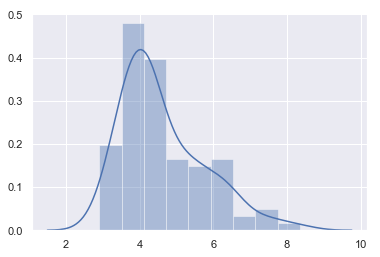

In [10]:
sns.distplot(rgb_rmses)

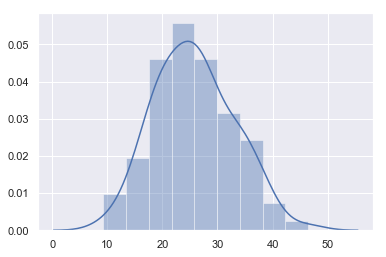

In [11]:
sns.distplot(rgb_delta_es)


If instead of RGB image we use XYZ image, the result would be as follows: 

In [12]:
print('xyz rmse mean is: ', np.mean(xyz_rmses), '\nxyz delta e mean is: ', np.mean(xyz_delta_es))

xyz rmse mean is:  1.2460264306489846 
xyz delta e mean is:  4.176421654198268


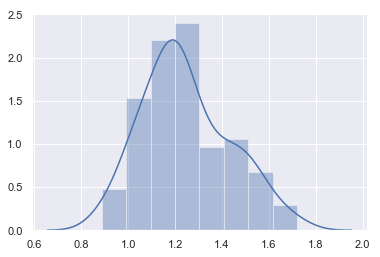

In [13]:
sns.distplot(xyz_rmses)

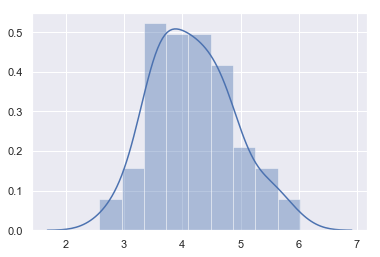

In [14]:
sns.distplot(xyz_delta_es)

Also, if instead of RGB image we use LAB image, the result would be as follows:

In [15]:
print('lab rmse mean is: ', np.mean(lab_rmses), '\nlab delta e mean is: ', np.mean(lab_delta_es))

lab rmse mean is:  5.9252079161534 
lab delta e mean is:  27.12708829135823


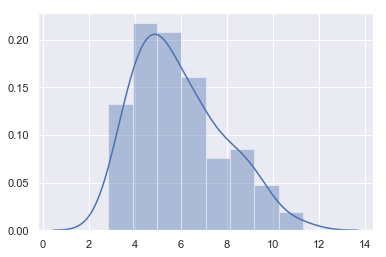

In [16]:
sns.distplot(lab_rmses)

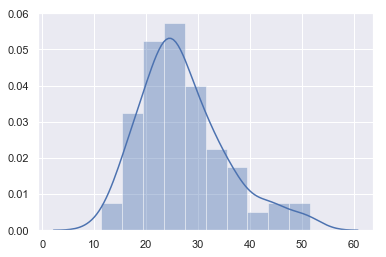

In [17]:
sns.distplot(lab_delta_es)

In [18]:
print('rgb mean rmses: ', np.mean(rgb_rmses), '\nxyz mean rmses: ', np.mean(xyz_rmses), 
      '\nlab mean rmses: ', np.mean(lab_rmses))

rgb mean rmses:  4.620166645038153 
xyz mean rmses:  1.2460264306489846 
lab mean rmses:  5.9252079161534


In [19]:
print('rgb mean delta e: ', np.mean(rgb_delta_es), '\nxyz mean delta e: ', np.mean(xyz_delta_es), 
      '\nlab mean delta e: ', np.mean(lab_delta_es))

rgb mean delta e:  25.794155759981923 
xyz mean delta e:  4.176421654198268 
lab mean delta e:  27.12708829135823


So using XYZ images for training has the best error.

Now let's try sp2xyz method with normalization and compare the results.

In [20]:
normalaized_rgb_rmses, normalaized_rgb_delta_es, normalaized_xyz_rmses, normalaized_xyz_delta_es, normalaized_lab_rmses, normalaized_lab_delta_es = get_results(normalize=True)

# print('normalize rgb rmse mean is: ', np.mean(normalaized_rgb_rmses),
#       ',normalize rgb delta e mean is: ', np.mean(normalaized_rgb_delta_es))

# print('normalize xyz rmse mean is: ', np.mean(normalaized_xyz_rmses), 
#       ',normalize xyz delta e mean is: ', np.mean(normalaized_xyz_delta_es))

# print('lab rmse mean is: ', np.mean(normalaized_lab_rmses), 
#       ',normalize lab delta e mean is: ', np.mean(normalaized_lab_delta_es))


In [21]:
print('rgb mean rmses: ', np.mean(rgb_rmses), ',', np.mean(normalaized_rgb_rmses), ': normalize rgb mean rmses', 
      '\nxyz mean rmses: ', np.mean(xyz_rmses), ',', np.mean(normalaized_xyz_rmses), ': normalize xyz mean rmses', 
      '\nlab mean rmses: ', np.mean(lab_rmses), ',', np.mean(normalaized_lab_rmses), ': normalize lab mean rmses'
     )

print()
print('rgb mean delta e: ', np.mean(rgb_delta_es), ',', np.mean(normalaized_rgb_delta_es), ': normalize rgb mean delta e',  
      '\nxyz mean delta e: ', np.mean(xyz_delta_es), ',', np.mean(normalaized_xyz_delta_es), ': normalize xyz mean delta e',
      '\nlab mean delta e: ', np.mean(lab_delta_es), ',', np.mean(normalaized_lab_delta_es), ': normalize lab mean delta e'
     )

rgb mean rmses:  4.620166645038153 , 4.6561022363377935 : normalize rgb mean rmses 
xyz mean rmses:  1.2460264306489846 , 1.1809523065174001 : normalize xyz mean rmses 
lab mean rmses:  5.9252079161534 , 5.507191206525671 : normalize lab mean rmses

rgb mean delta e:  25.794155759981923 , 0.0022978849008701923 : normalize rgb mean delta e 
xyz mean delta e:  4.176421654198268 , 0.0008247337507643332 : normalize xyz mean delta e 
lab mean delta e:  27.12708829135823 , 0.002536848225194685 : normalize lab mean delta e


As you see doing sp2xyz with normalization has better delta e error.

Now let's try the model for patches_size=1.

In [22]:
rgb_rmses_1, rgb_delta_es_1, xyz_rmses_1, xyz_delta_es_1, lab_rmses_1, lab_delta_es_1 = get_results(patches_size=1)
normalaized_rgb_rmses_1, normalaized_rgb_delta_es_1, normalaized_xyz_rmses_1, normalaized_xyz_delta_es_1, normalaized_lab_rmses_1, normalaized_lab_delta_es_1 = get_results(normalize=True, patches_size=1)


In [23]:
print('results for patch_size = 1 \n')

print('rgb mean rmses: ', np.mean(rgb_rmses_1), ',', np.mean(normalaized_rgb_rmses_1), ': normalize rgb mean rmses', 
      '\nxyz mean rmses: ', np.mean(xyz_rmses_1), ',', np.mean(normalaized_xyz_rmses_1), ': normalize xyz mean rmses', 
      '\nlab mean rmses: ', np.mean(lab_rmses_1), ',', np.mean(normalaized_lab_rmses_1), ': normalize lab mean rmses'
     )

print()
print('rgb mean delta e: ', np.mean(rgb_delta_es_1), ',', np.mean(normalaized_rgb_delta_es_1), ': normalize rgb mean delta e',  
      '\nxyz mean delta e: ', np.mean(xyz_delta_es_1), ',', np.mean(normalaized_xyz_delta_es_1), ': normalize xyz mean delta e',
      '\nlab mean delta e: ', np.mean(lab_delta_es_1), ',', np.mean(normalaized_lab_delta_es_1), ': normalize lab mean delta e'
     )



results for patch_size = 1 

rgb mean rmses:  0.05292729766564034 , 0.05158530707699261 : normalize rgb mean rmses 
xyz mean rmses:  0.013455648098081627 , 0.013624248110201137 : normalize xyz mean rmses 
lab mean rmses:  0.05628642911250407 , 0.057983612132392406 : normalize lab mean rmses

rgb mean delta e:  6.984102356239228 , 0.002415822636066857 : normalize rgb mean delta e 
xyz mean delta e:  2.6971225340788205 , 0.000832844846317169 : normalize xyz mean delta e 
lab mean delta e:  7.062112321888417 , 0.0026731261924575083 : normalize lab mean delta e


In [24]:
print('compare effect of patche size\n')

print('rgb mean rmses: ', np.mean(rgb_rmses), ',', np.mean(rgb_rmses_1), ': rgb mean rmses patch size 1', 
      '\nxyz mean rmses: ', np.mean(xyz_rmses), ',', np.mean(xyz_rmses_1), ': xyz mean rmses patch size 1', 
      '\nlab mean rmses: ', np.mean(lab_rmses), ',', np.mean(lab_rmses_1), ': lab mean rmses patch size 1'
     )

print()
print('rgb mean delta_e: ', np.mean(rgb_delta_es), ',', np.mean(rgb_delta_es_1), ': rgb mean delta_e patch size 1',  
      '\nxyz mean delta_e: ', np.mean(xyz_delta_es), ',', np.mean(xyz_delta_es_1), ': xyz mean delta_e patch size 1',
      '\nlab mean delta_e: ', np.mean(lab_delta_es), ',', np.mean(lab_delta_es_1), ': lab mean delta_e patch size 1'
     )
print()
print('normalize rgb mean delta_e: ', np.mean(normalaized_rgb_delta_es), ',', np.mean(normalaized_rgb_delta_es_1), ': normalize rgb mean delta_e patch size 1',  
      '\nnormalize xyz mean delta_e: ', np.mean(normalaized_xyz_delta_es), ',', np.mean(normalaized_xyz_delta_es_1), ': normalize xyz mean delta_e patch size 1',
      '\nnormalize lab mean delta_e: ', np.mean(normalaized_lab_delta_es), ',', np.mean(normalaized_lab_delta_es_1), ': normalize lab mean delta_e patch size 1'
     )

compare effect of patche size

rgb mean rmses:  4.620166645038153 , 0.05292729766564034 : rgb mean rmses patch size 1 
xyz mean rmses:  1.2460264306489846 , 0.013455648098081627 : xyz mean rmses patch size 1 
lab mean rmses:  5.9252079161534 , 0.05628642911250407 : lab mean rmses patch size 1

rgb mean delta_e:  25.794155759981923 , 6.984102356239228 : rgb mean delta_e patch size 1 
xyz mean delta_e:  4.176421654198268 , 2.6971225340788205 : xyz mean delta_e patch size 1 
lab mean delta_e:  27.12708829135823 , 7.062112321888417 : lab mean delta_e patch size 1

normalize rgb mean delta_e:  0.0022978849008701923 , 0.002415822636066857 : normalize rgb mean delta_e patch size 1 
normalize xyz mean delta_e:  0.0008247337507643332 , 0.000832844846317169 : normalize xyz mean delta_e patch size 1 
normalize lab mean delta_e:  0.002536848225194685 , 0.0026731261924575083 : normalize lab mean delta_e patch size 1


As you see patch size = 1 is much more better than patch size = PATCH_SIZE.